## Hey, what's that sound? A visual differentiator of string instruments

The objective of this model is to differentiate a few string instruments to make it more comprehensive to separate them

To prepare the model we'll take the following steps:

1. Use DuckDuckGo to search for pictures of cavaquinhos
1. Use DuckDuckGo to search for pictures of violins
1. Use DuckDuckGo to search for pictures of guitar
1. Fine-Tune the pre built neural network
1. Test it with each of the animals we searched

## Step 1: Downloading the necessary images


In [151]:
# Skip this cell if you already have duckduckgo_search installed
!pip install -Uqq duckduckgo_search
from fastai.vision.widgets import *

In [152]:
from duckduckgo_search import ddg_images
from fastcore.all import *

def search_images(term, max_images=200): return L(ddg_images(term, max_results=max_images)).itemgot('image')

In [153]:
urls = search_images('cavaquinho', max_images=1)
urls[0]

/usr/local/lib/python3.10/dist-packages/duckduckgo_search/compat.py:60: UserWarning: ddg_images is deprecated. Use DDGS().images() generator
  warnings.warn("ddg_images is deprecated. Use DDGS().images() generator")
/usr/local/lib/python3.10/dist-packages/duckduckgo_search/compat.py:64: UserWarning: parameter page is deprecated
  warnings.warn("parameter page is deprecated")
/usr/local/lib/python3.10/dist-packages/duckduckgo_search/compat.py:66: UserWarning: parameter max_results is deprecated
  warnings.warn("parameter max_results is deprecated")


'https://luthiermarciano.com.br/wp-content/uploads/2017/08/cavaquinho-são-paulo-comprar-e1504702909400.jpg'

Download examples

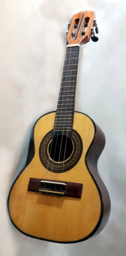

In [154]:
from fastdownload import download_url
dest = 'cavaquinho.jpg'
download_url(urls[0], dest, show_progress=False)

from fastai.vision.all import *
im = Image.open(dest)
im.to_thumb(256,256)

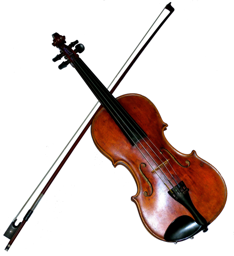

In [155]:
download_url(search_images('violin', max_images=1)[0], 'violin.jpg', show_progress=False)
Image.open('violin.jpg').to_thumb(256,256)

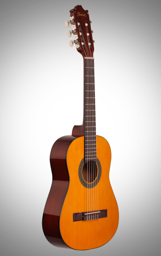

In [156]:
download_url(search_images('guitar', max_images=1)[0], 'guitar.jpg', show_progress=False)
Image.open('guitar.jpg').to_thumb(256,256)

### Downloading search result images for Dataset

In [168]:
searches = 'cavaquinho','guitar','violin'
path = Path('cavaquinho_guitar_violin')
from time import sleep

for o in searches:
    dest = (path/o)
    dest.mkdir(exist_ok=True, parents=True)
    download_images(dest, urls=search_images(f'acoustic {o} photo')) #Remove electric versions
    sleep(1)  # Pause between searches to avoid over-loading server
    download_images(dest, urls=search_images(f'{o} instrument photo'))
    sleep(1)
    resize_images(path/o, max_size=400, dest=path/o)

/usr/local/lib/python3.10/dist-packages/duckduckgo_search/compat.py:60: UserWarning: ddg_images is deprecated. Use DDGS().images() generator
  warnings.warn("ddg_images is deprecated. Use DDGS().images() generator")
/usr/local/lib/python3.10/dist-packages/duckduckgo_search/compat.py:64: UserWarning: parameter page is deprecated
  warnings.warn("parameter page is deprecated")
/usr/local/lib/python3.10/dist-packages/duckduckgo_search/compat.py:66: UserWarning: parameter max_results is deprecated
  warnings.warn("parameter max_results is deprecated")
/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


## Step 2: Train our model

Some photos might not download correctly which could cause our model training to fail, so we'll remove them:

In [169]:
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)

14

To train a model, we'll need `DataLoaders`, which is an object that contains a *training set* (the images used to create a model) and a *validation set* (the images used to check the accuracy of a model -- not used during training). In `fastai` we can create that easily using a `DataBlock`, and view sample images from it:

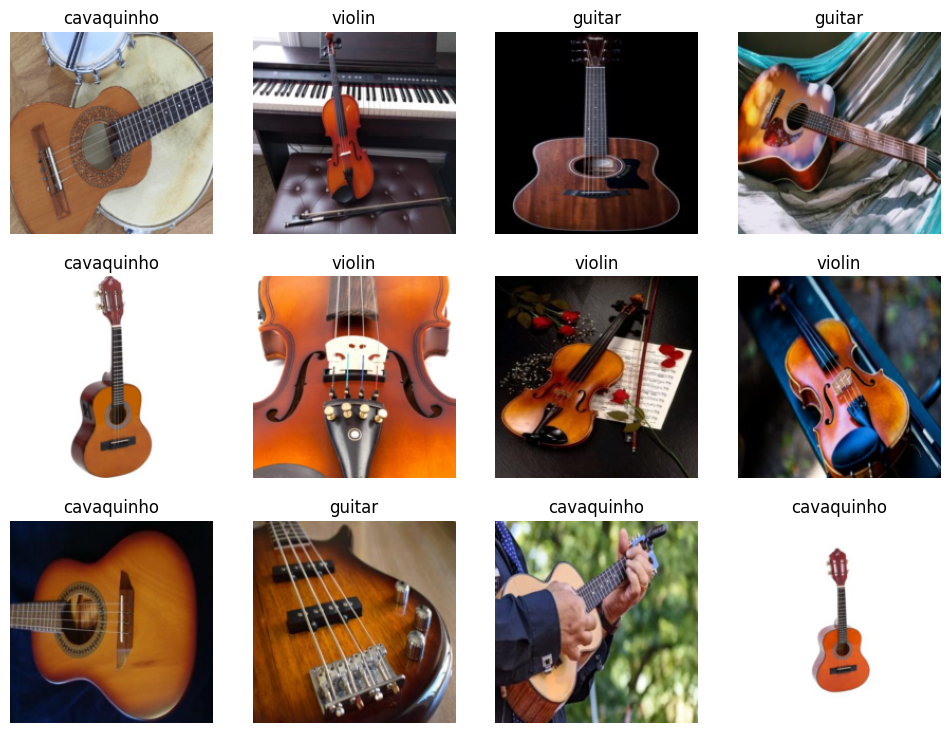

In [170]:
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(192, method='squish')]
).dataloaders(path)

dls.show_batch(max_n=12)

In [171]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(2)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


epoch,train_loss,valid_loss,error_rate,time
0,1.169836,0.380713,0.141935,00:06


epoch,train_loss,valid_loss,error_rate,time
0,0.388410,0.285898,0.070968,00:08
1,0.247073,0.273652,0.077419,00:06


## Step 3: Using the model

Let's see some example tests of what are model thinks and the actual result:

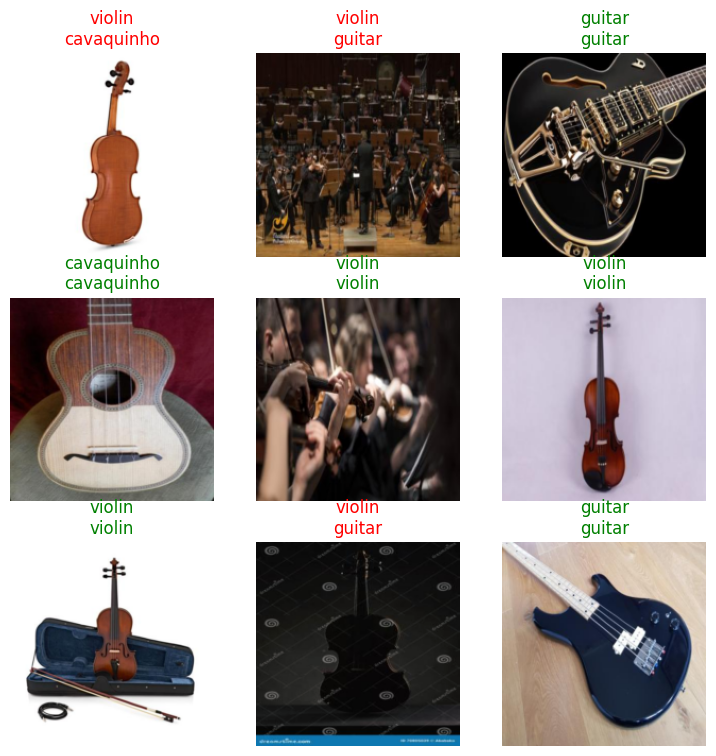

In [172]:
learn.show_results(max_n=9)

### Cleaning Up
Here we have the opportunity to improve our dataset by removing images that don't match our topic or relabel images that may have been mislabeled.

In [178]:
cleaner = ImageClassifierCleaner(learn)

cleaner

### Testing
Now we'll train our model on the previous example images to check if it's getting the results correctly.

This is a: cavaquinho.
Probability it's a cavaquinho: 0.9986


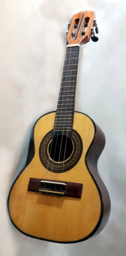

In [183]:
item="cavaquinho.jpg"
is_cavaco,_,probs = learn.predict(PILImage.create(item))
print(f"This is a: {is_cavaco}.")
print(f"Probability it's a cavaquinho: {probs[0]:.4f}")
im = Image.open(item)
im.to_thumb(256,256)

This is a: guitar.
Probability it's a cavaquinho: 0.0072


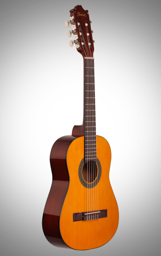

In [184]:
item="guitar.jpg"
is_cavaco,_,probs = learn.predict(PILImage.create(item))
print(f"This is a: {is_cavaco}.")
print(f"Probability it's a cavaquinho: {probs[0]:.4f}")
im = Image.open(item)
im.to_thumb(256,256)

This is a: violin.
Probability it's a cavaquinho: 0.0000


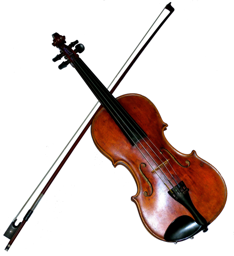

In [185]:
item="violin.jpg"
is_cavaco,_,probs = learn.predict(PILImage.create(item))
print(f"This is a: {is_cavaco}.")
print(f"Probability it's a cavaquinho: {probs[0]:.4f}")
im = Image.open(item)
im.to_thumb(256,256)

In [186]:
learn.export("instruments_model.pkl")

# Give it a shot!
The model related to this article has been deployed on the following link where using gradio it's possible not only to check the tests previously shown here, but also test it with your own images. Just click [here!](https://huggingface.co/spaces/AlGouvea/ML_Entrega_2)
